<a href="https://colab.research.google.com/github/JingWang98/Text-Mining-and-Sentiment-Analysis-Project/blob/main/I_Hate_You.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I hate you
# Text mining and sentiment analysis
## Author: Jing Wang
## Accademic Year: 2023-2024

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.9 MB/s eta 0:00:00


In [2]:
import keras_tuner as kt
import re
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dropout, Dense, BatchNormalization, LSTM
import tensorflow as tf
from keras_tuner import HyperParameters
from sklearn.model_selection import KFold

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

Define some functions

In [5]:
# Function for clean_text
def clean_text(text):
    if isinstance(text, str):  # Ensure input is a string
        # Convert to lowercase
        text = text.lower()

        # Remove web links
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Remove special characters
        text = re.sub(r'[^\w\s\']', '', text)

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        return text
    return text

# Function for lemmatization
def lemmatize_text(text):
    # Tokenize text into words
    words = nltk.word_tokenize(text)
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join lemmatized words back into a sentence
    return " ".join(lemmatized_words)

# Map nltk POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_with_pos(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)  # Get POS tags for words
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags
    ]
    return " ".join(lemmatized_words)

# functions for the plots loss and accuracy
def performance_plot(history):
    step=int(len(history.history['loss'])/10)

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color = 'red')
    plt.plot(history.history['val_loss'], color = 'orange')
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)


    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))
    plt.yticks(np.arange(0, 1, step=0.1))

    plt.grid(alpha=.25)
    plt.legend(['Train', 'Val'])
    plt.title("Loss over epoch")

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color = 'red')
    plt.plot(history.history['val_accuracy'],color = 'orange')
    plt.ylabel('Accuracy', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['Train', 'Val'])
    plt.title("Accuracy over epoch")
    plt.grid(alpha=.25)
    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))
    plt.yticks(np.arange(0, 1, step=0.1))

    plt.show()


# set seed
def custom_seed_set():
    np.random.seed(42)
    tf.random.set_seed(42)

In [6]:

!wget https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/refs/heads/master/annotations_metadata.csv



--2025-01-15 21:23:22--  https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/refs/heads/master/annotations_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348556 (340K) [text/plain]
Saving to: ‘annotations_metadata.csv’

annotations_metadat 100%[===================>] 340.39K  --.-KB/s    in 0.006s  

2025-01-15 21:23:22 (53.5 MB/s) - ‘annotations_metadata.csv’ saved [348556/348556]



In [7]:
!git clone https://github.com/Vicomtech/hate-speech-dataset

!ls hate-speech-dataset/all_files| wc -l

Cloning into 'hate-speech-dataset'...
remote: Enumerating objects: 10785, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10785 (delta 6), reused 0 (delta 0), pack-reused 10771 (from 1)
Receiving objects: 100% (10785/10785), 1.16 MiB | 12.16 MiB/s, done.
Resolving deltas: 100% (9/9), done.
10944


In [8]:
folder_path = "/content/hate-speech-dataset/all_files"

In [9]:
file_texts = {}

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            content = file.read().strip()
            file_texts[filename] = content

In [10]:
df = pd.DataFrame(list(file_texts.items()), columns=["Filename", "Text"])
# Remove '.txt' from the column
df['Filename'] = df['Filename'].str.replace('.txt', '', regex=False)

# Display the updated DataFrame
print(df)

         Filename                                               Text
0      14107297_3                                          Welcome .
1      33141763_1  Now that is good news as I frequently heard am...
2      13480925_2  Its only 1 extra kid than we normally have and...
3      30704903_3  Softly bright or radiant ; luminous ; as , `` ...
4      13857882_1  Does Ireland have a party that is similar to o...
...           ...                                                ...
10939  30698771_1  Incredible then when we see nowadays that the ...
10940  30966286_1  I feel very sorry for the families of such Jew...
10941  14082630_2                       She is certainly an enigma .
10942  13269862_2  I ca n't wait till the news starts promoting r...
10943  14027556_1  May I share with the good people on this board...

[10944 rows x 2 columns]


In [11]:
Annotations = pd.read_csv('/content/annotations_metadata.csv')
Annotations

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate
...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate
10940,33677019_1,735154,1388,0,noHate
10941,33677019_2,735154,1388,0,noHate
10942,33677053_1,572266,1388,0,hate


In [12]:
# Perform left join with different column names
Final_df = pd.merge(df, Annotations, left_on='Filename', right_on='file_id', how='left')
Final_df

,Filename,Text,file_id,user_id,subforum_id,num_contexts,label
0,14107297_3,Welcome .,14107297_3,573700,1381,0,noHate
1,33141763_1,Now that is good news as I frequently heard am...,33141763_1,572490,1396,0,noHate
2,13480925_2,Its only 1 extra kid than we normally have and...,13480925_2,580712,1346,0,noHate
3,30704903_3,"Softly bright or radiant ; luminous ; as , `` ...",30704903_3,573581,1362,0,noHate
4,13857882_1,Does Ireland have a party that is similar to o...,13857882_1,577797,1391,0,noHate
...,...,...,...,...,...,...,...
10939,30698771_1,Incredible then when we see nowadays that the ...,30698771_1,572191,1354,0,noHate
10940,30966286_1,I feel very sorry for the families of such Jew...,30966286_1,575465,1346,0,noHate
10941,14082630_2,She is certainly an enigma .,14082630_2,572182,1381,0,noHate
10942,13269862_2,I ca n't wait till the news starts promoting r...,13269862_2,572208,1345,0,noHate


In [13]:
# Keep rows with unique values in 'Filename'
Final_df_unique = Final_df.drop_duplicates(subset='Filename', keep=False)
Final_df_unique

,Filename,Text,file_id,user_id,subforum_id,num_contexts,label
0,14107297_3,Welcome .,14107297_3,573700,1381,0,noHate
1,33141763_1,Now that is good news as I frequently heard am...,33141763_1,572490,1396,0,noHate
2,13480925_2,Its only 1 extra kid than we normally have and...,13480925_2,580712,1346,0,noHate
3,30704903_3,"Softly bright or radiant ; luminous ; as , `` ...",30704903_3,573581,1362,0,noHate
4,13857882_1,Does Ireland have a party that is similar to o...,13857882_1,577797,1391,0,noHate
...,...,...,...,...,...,...,...
10939,30698771_1,Incredible then when we see nowadays that the ...,30698771_1,572191,1354,0,noHate
10940,30966286_1,I feel very sorry for the families of such Jew...,30966286_1,575465,1346,0,noHate
10941,14082630_2,She is certainly an enigma .,14082630_2,572182,1381,0,noHate
10942,13269862_2,I ca n't wait till the news starts promoting r...,13269862_2,572208,1345,0,noHate


In [14]:
Data = Final_df_unique[['Text','label']]
Data.head()

,Text,label
0,Welcome .,noHate
1,Now that is good news as I frequently heard am...,noHate
2,Its only 1 extra kid than we normally have and...,noHate
3,"Softly bright or radiant ; luminous ; as , `` ...",noHate
4,Does Ireland have a party that is similar to o...,noHate


In [15]:
Data['label'].unique()

array(['noHate', 'hate', 'relation', 'idk/skip'], dtype=object)

In [16]:
counts = Data['label'].value_counts()
print(counts)

label
noHate      9507
hate        1196
relation     168
idk/skip      73
Name: count, dtype: int64


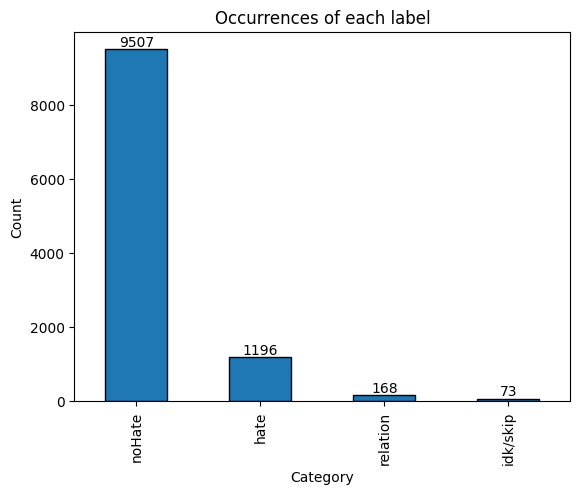

In [17]:
# Create the bar plot
ax = counts.plot(kind='bar', color='#1f77b4', edgecolor='black')
for i, count in enumerate(counts):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Occurrences of each label')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [18]:
Data[Data['label'] == 'hate'].iloc[0]['Text']

"Apparently the Jews ca n't take it when the truth is spoken about them ."

In [19]:
Data[Data['label'] == 'noHate'].iloc[0]['Text']

'Welcome .'

In [20]:
Data[Data['label'] == 'relation'].iloc[0]['Text']

'Somehow I think maybe your a troll .'

In [21]:
Data[Data['label'] == 'idk/skip'].iloc[0]['Text']

'Glædelig jul !'

In [22]:
# Count the number of null values in each column
null_counts = Data.isnull().sum()

# Display the count of null values in each column
print(null_counts)

Text     0
label    0
dtype: int64


I decided to keep only "Hate" and "noHate"

In [23]:
# Drop rows where 'label' is 'relation' or 'idk/skip'
Data = Data[~Data['label'].isin(['relation', 'idk/skip'])]

print("Filtered DataFrame:")
Data.head()

Filtered DataFrame:


,Text,label
0,Welcome .,noHate
1,Now that is good news as I frequently heard am...,noHate
2,Its only 1 extra kid than we normally have and...,noHate
3,"Softly bright or radiant ; luminous ; as , `` ...",noHate
4,Does Ireland have a party that is similar to o...,noHate


In [24]:
# Replace values in the 'label' column
Data['label'] = Data['label'].replace({'noHate': 0, 'hate': 1})
Data

<ipython-input-24-2da7c150acb8>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['label'] = Data['label'].replace({'noHate': 0, 'hate': 1})


,Text,label
0,Welcome .,0
1,Now that is good news as I frequently heard am...,0
2,Its only 1 extra kid than we normally have and...,0
3,"Softly bright or radiant ; luminous ; as , `` ...",0
4,Does Ireland have a party that is similar to o...,0
...,...,...
10939,Incredible then when we see nowadays that the ...,0
10940,I feel very sorry for the families of such Jew...,0
10941,She is certainly an enigma .,0
10942,I ca n't wait till the news starts promoting r...,0


Data preprocessing

1. Lowercasing
2. Removing web links
3. Removing special characters
4. Remove numbers
5. Lemmatization


In [25]:
Data['Text'] = Data['Text'].apply(clean_text)
Data

,Text,label
0,welcome,0
1,now that is good news as i frequently heard am...,0
2,its only extra kid than we normally have and ...,0
3,softly bright or radiant luminous as a lam...,0
4,does ireland have a party that is similar to o...,0
...,...,...
10939,incredible then when we see nowadays that the ...,0
10940,i feel very sorry for the families of such jew...,0
10941,she is certainly an enigma,0
10942,i ca n't wait till the news starts promoting r...,0


In [26]:
# Initialize the Lemmatizer
lemmatizer = WordNetLemmatizer()

In [27]:
Data['Text'] = Data['Text'].apply(lemmatize_with_pos)
Data

,Text,label
0,welcome,0
1,now that be good news a i frequently hear amon...,0
2,it only extra kid than we normally have and if...,0
3,softly bright or radiant luminous a a lambent ...,0
4,do ireland have a party that be similar to our...,0
...,...,...
10939,incredible then when we see nowadays that the ...,0
10940,i feel very sorry for the family of such jew a...,0
10941,she be certainly an enigma,0
10942,i ca n't wait till the news start promote raci...,0


In [28]:
# make a copy of dataframe "Data"
Data_new = Data.copy()
Data_new

,Text,label
0,welcome,0
1,now that be good news a i frequently hear amon...,0
2,it only extra kid than we normally have and if...,0
3,softly bright or radiant luminous a a lambent ...,0
4,do ireland have a party that be similar to our...,0
...,...,...
10939,incredible then when we see nowadays that the ...,0
10940,i feel very sorry for the family of such jew a...,0
10941,she be certainly an enigma,0
10942,i ca n't wait till the news start promote raci...,0


In [29]:
# Count the number of words in each row
Data_new['Word_Count'] = Data_new['Text'].str.split().str.len()

print(Data_new)

                                                    Text  label  Word_Count
0                                                welcome      0           1
1      now that be good news a i frequently hear amon...      0          25
2      it only extra kid than we normally have and if...      0          29
3      softly bright or radiant luminous a a lambent ...      0          10
4      do ireland have a party that be similar to our...      0          14
...                                                  ...    ...         ...
10939  incredible then when we see nowadays that the ...      0          47
10940  i feel very sorry for the family of such jew a...      0          43
10941                         she be certainly an enigma      0           5
10942  i ca n't wait till the news start promote raci...      0          26
10943  may i share with the good people on this board...      0          27

[10703 rows x 3 columns]


In [30]:
Data_new['Word_Count'].mean()

16.06138465850696

PMI

In [31]:
hate_texts = Data_new[Data_new['label'] == 1]['Text']
nohate_texts = Data_new[Data_new['label'] == 0]['Text']


In [32]:
# Tokenize and count word frequencies
vectorizer = CountVectorizer()
hate_matrix = vectorizer.fit_transform(hate_texts)
nohate_matrix = vectorizer.transform(nohate_texts)

# Get word frequencies for each category
hate_word_counts = hate_matrix.sum(axis=0).A1
nohate_word_counts = nohate_matrix.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()


In [33]:
hate_word_counts

array([1, 1, 9, ..., 1, 1, 1])

In [34]:
# Total word counts
total_hate_words = hate_word_counts.sum()
total_nohate_words = nohate_word_counts.sum()
total_words = total_hate_words + total_nohate_words

# Marginal probabilities
P_hate = total_hate_words / total_words
P_nohate = total_nohate_words / total_words

# Word probabilities
P_w_hate = hate_word_counts / total_words
P_w_nohate = nohate_word_counts / total_words
P_w = (hate_word_counts + nohate_word_counts) / total_words

# PMI calculations
PMI_hate = np.log(P_w_hate / (P_w * P_hate + 1e-10))  # Add small value to avoid division by zero
PMI_nohate = np.log(P_w_nohate / (P_w * P_nohate + 1e-10))


<ipython-input-34-0bb59e0f4ddc>:17: RuntimeWarning: divide by zero encountered in log
  PMI_nohate = np.log(P_w_nohate / (P_w * P_nohate + 1e-10))


In [35]:
# HATE Score calculation
HS = PMI_hate - PMI_nohate
HS[np.isinf(HS)] = 0

# Create a DataFrame for easy interpretation
hate_score_df = pd.DataFrame({
    'Word': vocab,
    'PMI_HATE': PMI_hate,
    'PMI_NOHATE': PMI_nohate,
    'HATE_Score': HS
})

# Sort by HATE Score
hate_score_df = hate_score_df.sort_values(by='HATE_Score', ascending=True)
print(hate_score_df)


         Word  PMI_HATE  PMI_NOHATE  HATE_Score
3294   thanks -2.681998    0.179159   -2.861157
1559     idea -2.410064    0.175387   -2.585451
986     email -2.221474    0.172087   -2.393560
250      band -2.221474    0.172087   -2.393560
3586    water -2.202425    0.171717   -2.374142
...       ...       ...         ...         ...
1159   filthy  1.594663   -1.754776    3.349440
1758   jungle  1.615278   -1.888308    3.503587
1864  libtard  1.615278   -1.888308    3.503587
1356    groid  1.615283   -1.888307    3.503591
1158    filth  1.623652   -1.948932    3.572584

[3742 rows x 4 columns]


In [36]:
# Sort the DataFrame by HATE Score in descending order
top_hate_terms = hate_score_df.sort_values(by='HATE_Score', ascending=False).head(10)

# Print the top 10 terms and their scores
print(top_hate_terms[['Word', 'HATE_Score']])

         Word  HATE_Score
1158    filth    3.572584
1356    groid    3.503591
1758   jungle    3.503587
1864  libtard    3.503587
1159   filthy    3.349440
2098  mongrel    3.349435
161       ape    3.321272
2962   sicken    3.167112
1679   invade    3.167112
2246     nigs    3.167112


In [37]:
# Sort the DataFrame by HATE Score in ascending order
top_noHate_terms = hate_score_df.sort_values(by='HATE_Score', ascending=True).head(10)

# Print the top 10 terms and their scores
print(top_noHate_terms[['Word', 'HATE_Score']])

            Word  HATE_Score
3294      thanks   -2.861157
1559        idea   -2.585451
986        email   -2.393560
250         band   -2.393560
3586       water   -2.374142
3480  university   -2.354340
3441        type   -2.270958
1403       happy   -2.248979
2503          pm   -2.248979
1880        link   -2.215077


<ipython-input-38-e0130ffbf5c7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Word', y='HATE_Score', data=top_hate_terms, palette='Blues_r')


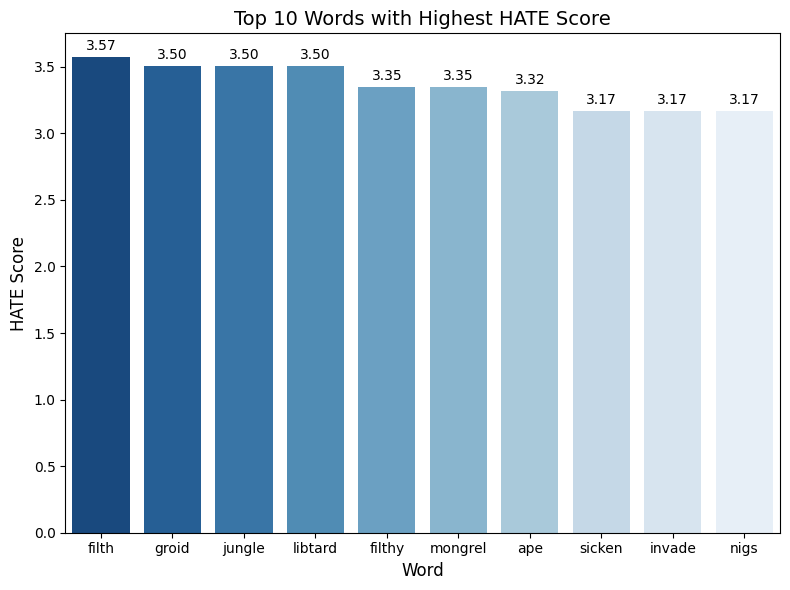

In [38]:
# Plot a bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Word', y='HATE_Score', data=top_hate_terms, palette='Blues_r')

for i, count in enumerate(top_hate_terms['HATE_Score']):
    ax.text(i, count + 0.03, f'{count:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Word', fontsize=12)
plt.ylabel('HATE Score', fontsize=12)
plt.title('Top 10 Words with Highest HATE Score', fontsize=14)
plt.tight_layout()
plt.show()

In [39]:
Data_new = Data_new[['label', 'Text']]
Data_new

,label,Text
0,0,welcome
1,0,now that be good news a i frequently hear amon...
2,0,it only extra kid than we normally have and if...
3,0,softly bright or radiant luminous a a lambent ...
4,0,do ireland have a party that be similar to our...
...,...,...
10939,0,incredible then when we see nowadays that the ...
10940,0,i feel very sorry for the family of such jew a...
10941,0,she be certainly an enigma
10942,0,i ca n't wait till the news start promote raci...


In [40]:
# Separate records by label
Hate_df = Data_new[Data_new['label'] == 1]  # All records with label = 1
noHate_df = Data_new[Data_new['label'] == 0]
# Randomly sample 2500 records from noHate_df
nohate_texts_sampled = noHate_df.sample(n=2500, random_state=42)

# Combine the two subsets
balanced_df = pd.concat([Hate_df, nohate_texts_sampled])

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the resulting balanced DataFrame
print(balanced_df)

      label                                               Text
0         1     like i say before i 'd bet have liberal parent
1         1  not to mention that they do n't belong here an...
2         1  what a load of crapwater be ye people for real...
3         0  i be look for anything where i can be among my...
4         0                      i do n't dare to look at them
...     ...                                                ...
3691      1  and it ai n't your daddy 's new world order ei...
3692      0  restaurant summer skadarlija ima dana `` resta...
3693      1  so accord to your logic since black have be in...
3694      0  i be a right sector supporter but it start to ...
3695      0                   this be such an exciting project

[3696 rows x 2 columns]


In [41]:
# training and test set
X = balanced_df['Text']
y = balanced_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (3696,)
shape of target variable:  (3696,)


In [42]:
X_train

,Text
2887,no the truth white powerwhite victorywhite pride
2715,after you realize that you will never be accep...
818,watch those videos make me feel like im go to ...
3559,so even if it be show n a bad light i would ho...
2578,i live in stevens point
...,...
1130,the person who do that will also make history ...
1294,i ca n't fathom see all those brainless white ...
860,i 've hear that men with aid in africa think h...
3507,i think i may know this person it 's me and i ...


In [43]:
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

Number of training samples: 2956
Number of testing samples: 740


In [44]:
tokenizer = Tokenizer(num_words=15000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strings into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20, padding='post') # pads the integer lists to 2D integer tensor

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20, padding='post')

word_index = tokenizer.word_index
max_words = 10000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence
print("Length of word index:", total_words)


Length of word index: 6152


In [45]:
print("Sample Sequence:", train_padseq[0])  # Check if the sequences are valid
print("Shape of Sequences:", train_padseq.shape)

Sample Sequence: [  59    2  296   16 2714 2715  456    0    0    0    0    0    0    0
    0    0    0    0    0    0]
Shape of Sequences: (2956, 20)


In [46]:
total_words

6152

In [47]:
print(train_padseq.shape)
print(test_padseq.shape)

(2956, 20)
(740, 20)


In [48]:
total_words= total_words+1

RNN

In [49]:
embedding_dim = 100
# Model Structure
model0 = Sequential()

# Embedding Layer: Converts input words to dense vectors of fixed size
model0.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Simple RNN Layer:
model0.add(SimpleRNN(64, activation='tanh'))
# Dropout layer for regularization
model0.add(Dropout(0.5))

# Dense Output Layer:
model0.add(Dense(1, activation='sigmoid'))


# Compile the Model
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [50]:
# fit model to the data
history0 = model0.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=10,
                    validation_data=(test_padseq, y_test)
                   )

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6629 - loss: 0.6066 - val_accuracy: 0.7270 - val_loss: 0.5315
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8490 - loss: 0.3760 - val_accuracy: 0.7351 - val_loss: 0.5091
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9522 - loss: 0.1689 - val_accuracy: 0.7446 - val_loss: 0.5976
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9737 - loss: 0.0901 - val_accuracy: 0.7405 - val_loss: 0.7542
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9943 - loss: 0.0295 - val_accuracy: 0.7270 - val_loss: 0.7963
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9963 - loss: 0.0196 - val_accuracy: 0.7459 - val_loss: 0.8682
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0146 - val_accuracy: 0.7270 - val_loss: 0.9400
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9992 - loss: 0.0061 - val_accuracy: 0.7392 - val_loss

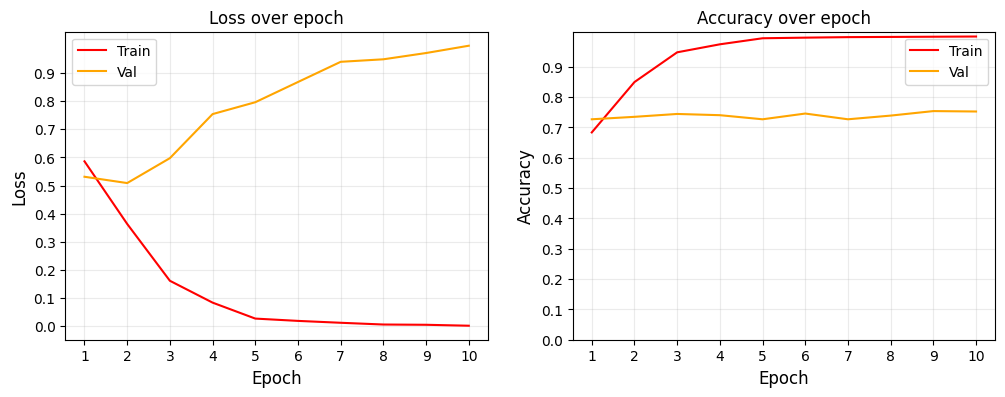

In [51]:
performance_plot(history0)

In [52]:
# Build the model
model1 = Sequential()

# Embedding Layer:
model1.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Bidirectional SimpleRNN Layer
model1.add(Bidirectional(SimpleRNN(64, dropout=0.3, recurrent_dropout=0.3, activation='relu', return_sequences=True)))

# Another Bidirectional SimpleRNN Layer
model1.add(Bidirectional(SimpleRNN(64, dropout=0.3, recurrent_dropout=0.3, activation='relu', return_sequences=True)))

# SimpleRNN Layer for the output
model1.add(SimpleRNN(32, activation='tanh'))

# Dropout layer for regularization
model1.add(Dropout(0.5))

# Dense layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
# fit model to the data
history1 = model1.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=15,
                    validation_data=(test_padseq, y_test)
                   )
# SETUP A EARLY STOPPING CALL
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.6307 - loss: 0.6602 - val_accuracy: 0.6514 - val_loss: 0.6072
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6738 - loss: 0.6077 - val_accuracy: 0.6770 - val_loss: 0.6003
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6955 - loss: 0.5885 - val_accuracy: 0.7081 - val_loss: 0.5887
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7368 - loss: 0.5477 - val_accuracy: 0.6973 - val_loss: 0.5960
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7860 - loss: 0.4695 - val_accuracy: 0.7257 - val_loss: 0.5618
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8326 - loss: 0.3746 - val_accuracy: 0.7216 - val_loss: 0.5999
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9167 - loss: 0.2572 - val_accuracy: 0.7027 - val_loss: 0.6618
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9539 - loss: 0.1576 - val_accuracy: 0.7176 -

In [54]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 20, 100)             │         615,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 128)             │          21,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 32)                  │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,998,929 (7.63 MB)

 Trainable params: 666,309 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,332,620 (5.08 MB)

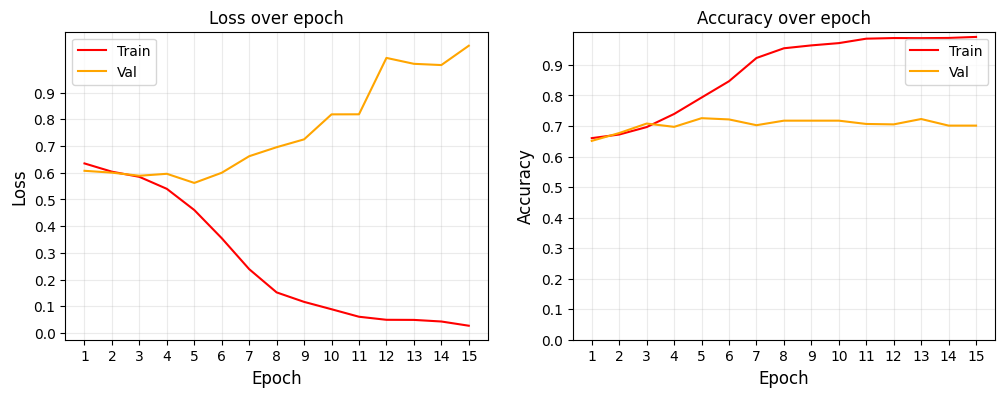

In [55]:
performance_plot(history1)

In [60]:
# Build the model
model2 = Sequential()

# Embedding Layer:
model2.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Bidirectional SimpleRNN Layer
model2.add(Bidirectional(SimpleRNN(128, dropout=0.3, recurrent_dropout=0.4, activation='relu', return_sequences=True)))

# Another Bidirectional SimpleRNN Layer
model2.add(Bidirectional(SimpleRNN(96, dropout=0.3, recurrent_dropout=0.5, activation='relu', return_sequences=True)))

# SimpleRNN Layer for the output
model2.add(SimpleRNN(64, activation='tanh'))

# Dropout layer for regularization
model2.add(Dropout(0.6))
model2.add(BatchNormalization())

# Dense layer
model2.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
# fit model to the data
history2 = model2.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=30,
                    validation_data=(test_padseq, y_test)
                   )

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 206ms/step - accuracy: 0.5030 - loss: 0.8706 - val_accuracy: 0.6541 - val_loss: 0.6668
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5543 - loss: 0.7902 - val_accuracy: 0.6608 - val_loss: 0.6478
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5716 - loss: 0.7565 - val_accuracy: 0.6608 - val_loss: 0.6418
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6074 - loss: 0.7150 - val_accuracy: 0.6608 - val_loss: 0.6368
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6120 - loss: 0.7368 - val_accuracy: 0.6608 - val_loss: 0.6324
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6170 - loss: 0.6989 - val_accuracy: 0.6608 - val_loss: 0.6309
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6363 - loss: 0.7027 - val_accuracy: 0.6608 - val_loss: 0.6214
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6409 - loss: 0.6701 - val_accuracy: 0.6608 - val_loss: 

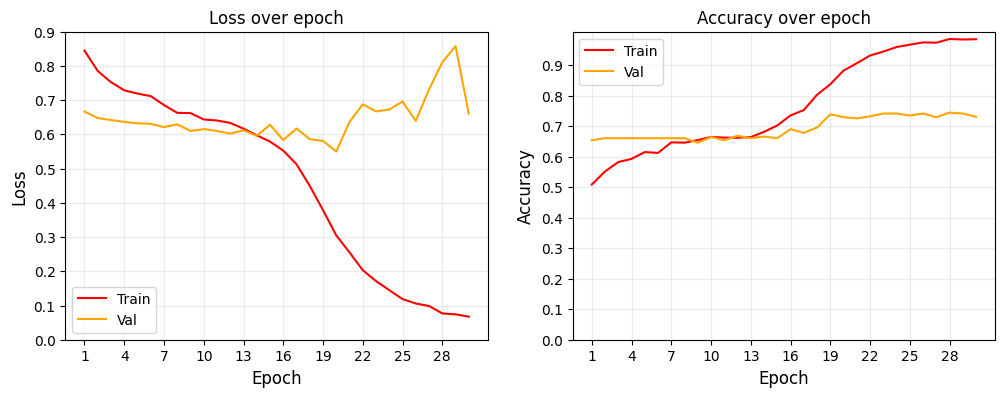

In [61]:
performance_plot(history2)

Hyperparameter Tuning

In [62]:
import shutil

# Clear the tuner directory to start fresh
# shutil.rmtree('my_dir', ignore_errors=True)  # Removes the entire directory

In [64]:
# Define the hypermodel
def build_model(hp):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=total_words,
                        output_dim=hp.Int('embedding_dim', min_value=50, max_value=150, step=50),
                        input_length=maxlen))

    # First Bidirectional RNN layer
    model.add(Bidirectional(SimpleRNN(128,
                                      dropout=hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1),
                                      recurrent_dropout=hp.Float('recurrent_dropout_1', min_value=0.3, max_value=0.5, step=0.1),
                                      activation='relu', return_sequences=True)))

    # Second Bidirectional RNN layer
    model.add(Bidirectional(SimpleRNN(96,
                                      dropout=hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1),
                                      recurrent_dropout=hp.Float('recurrent_dropout_2', min_value=0.3, max_value=0.5, step=0.1),
                                      activation='relu', return_sequences=True)))

    # Final RNN layer (output layer)
    model.add(SimpleRNN(units=hp.Int('units_3', min_value=32, max_value=64, step=32),
                        activation='tanh'))

    # Dropout layer for regularization
    model.add(Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.0005, 0.001, 0.0002])),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.BayesianOptimization(build_model,
                     objective='val_accuracy',  # maximize validation accuracy
                     max_trials=8,
                     executions_per_trial=1,
                     directory='my_dir',  # This will store the tuner results
                     project_name='rnn_tuning')


# Search for the best hyperparameters
tuner.search(train_padseq, y_train, epochs=20, validation_data=(test_padseq, y_test))

# Get the best model
best_model = tuner.get_best_models()[0]
best_model.summary()



Trial 8 Complete [00h 00m 56s]
val_accuracy: 0.6648648381233215

Best val_accuracy So Far: 0.7567567825317383
Total elapsed time: 00h 07m 13s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 100)             │         615,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 256)             │          58,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 20, 192)             │          67,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 758,469 (2.89 MB)

 Trainable params: 758,341 (2.89 MB)

 Non-trainable params: 128 (512.00 B)

In [65]:
tuner.results_summary()

Results summary
Results in my_dir/rnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
embedding_dim: 100
dropout_1: 0.4
recurrent_dropout_1: 0.5
dropout_2: 0.5
recurrent_dropout_2: 0.3
units_3: 64
dropout_3: 0.4
learning_rate: 0.001
Score: 0.7567567825317383

Trial 0 summary
Hyperparameters:
embedding_dim: 50
dropout_1: 0.5
recurrent_dropout_1: 0.3
dropout_2: 0.3
recurrent_dropout_2: 0.5
units_3: 32
dropout_3: 0.4
learning_rate: 0.001
Score: 0.7472972869873047

Trial 6 summary
Hyperparameters:
embedding_dim: 100
dropout_1: 0.5
recurrent_dropout_1: 0.3
dropout_2: 0.4
recurrent_dropout_2: 0.3
units_3: 64
dropout_3: 0.3
learning_rate: 0.001
Score: 0.7189189195632935

Trial 2 summary
Hyperparameters:
embedding_dim: 100
dropout_1: 0.4
recurrent_dropout_1: 0.4
dropout_2: 0.3
recurrent_dropout_2: 0.3
units_3: 64
dropout_3: 0.4
learning_rate: 0.001
Score: 0.7175675630569458

Trial 1 summary
Hyperparameters:
embedding_dim: 100
drop

In [69]:
# Build the model
model_best = Sequential()

# Embedding Layer:
model_best.add(Embedding(input_dim=total_words, output_dim=100, input_length=maxlen))

# Bidirectional SimpleRNN Layer
model_best.add(Bidirectional(SimpleRNN(128, dropout=0.4, recurrent_dropout=0.5, activation='relu', return_sequences=True)))

# Another Bidirectional SimpleRNN Layer
model_best.add(Bidirectional(SimpleRNN(96, dropout=0.5, recurrent_dropout=0.3, activation='relu', return_sequences=True)))

# SimpleRNN Layer for the output
model_best.add(SimpleRNN(64, activation='tanh'))

# Dropout layer for regularization
model_best.add(Dropout(0.4))
model_best.add(BatchNormalization())

# Dense layer
model_best.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model_best.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# fit model to the data
history_best = model_best.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=12,
                    validation_data=(test_padseq, y_test)
                   )
# SETUP A EARLY STOPPING CALL
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.5498 - loss: 0.8316 - val_accuracy: 0.6608 - val_loss: 0.6477
Epoch 2/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6074 - loss: 0.7249 - val_accuracy: 0.6608 - val_loss: 0.6457
Epoch 3/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6173 - loss: 0.7084 - val_accuracy: 0.6608 - val_loss: 0.6380
Epoch 4/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6185 - loss: 0.7010 - val_accuracy: 0.6608 - val_loss: 0.6268
Epoch 5/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6532 - loss: 0.6784 - val_accuracy: 0.6608 - val_loss: 0.6220
Epoch 6/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6556 - loss: 0.6435 - val_accuracy: 0.6676 - val_loss: 0.6137
Epoch 7/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6689 - loss: 0.6325 - val_accuracy: 0.6851 - val_loss: 0.6109
Epoch 8/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6804 - loss: 0.6321 - val_accuracy: 0.6662 - val_loss: 

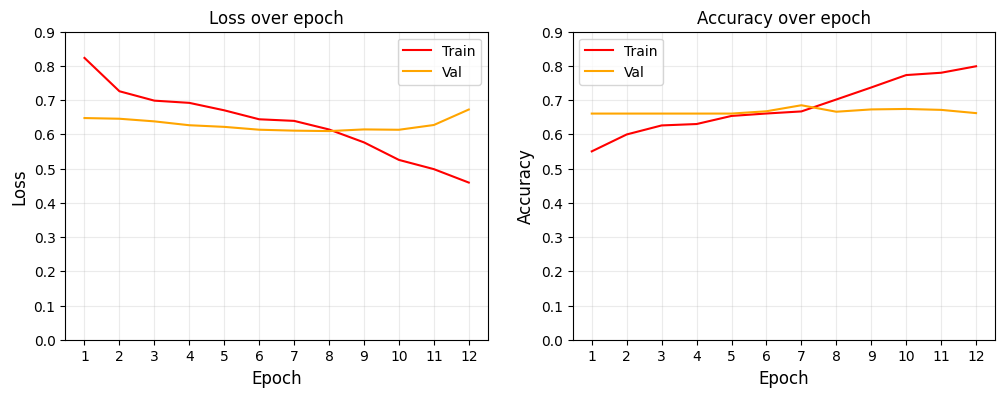

In [70]:
performance_plot(history_best)

In [71]:
model_best.evaluate(test_padseq, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6629 - loss: 0.6463


[0.6726537942886353, 0.662162184715271]

In [84]:
# Build the model
model_lstm = Sequential()

# Embedding Layer:
model_lstm.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Add an LSTM layer
model_lstm.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.5, activation='relu',return_sequences=True)))

# Add a second LSTM layer
model_lstm.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.5)))

# Dropout layer for regularization
model_lstm.add(Dropout(0.6))
model_best.add(BatchNormalization())

# Dense layer
model_lstm.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

# Compile the model
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Fit the model to the data
history_lstm = model_lstm.fit(
    train_padseq, y_train,
    batch_size=64,
    epochs=15,
    validation_data=(test_padseq, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
    ]
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.6656 - loss: 0.6755 - val_accuracy: 0.6608 - val_loss: 0.6219
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.6801 - loss: 0.5994 - val_accuracy: 0.6608 - val_loss: 0.5968
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.6797 - loss: 0.5903 - val_accuracy: 0.6608 - val_loss: 0.5938
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.6821 - loss: 0.5839 - val_accuracy: 0.6608 - val_loss: 0.5903
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.6842 - loss: 0.5686 - val_accuracy: 0.6608 - val_loss: 0.5882
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.6689 - loss: 0.5772 - val_accuracy: 0.6608 - val_loss: 0.5853
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.6871 - loss: 0.5598 - val_accuracy: 0.6635 - val_loss: 0.5804
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.6922 - loss: 0.5592 - val_accuracy: 0.6865 - v

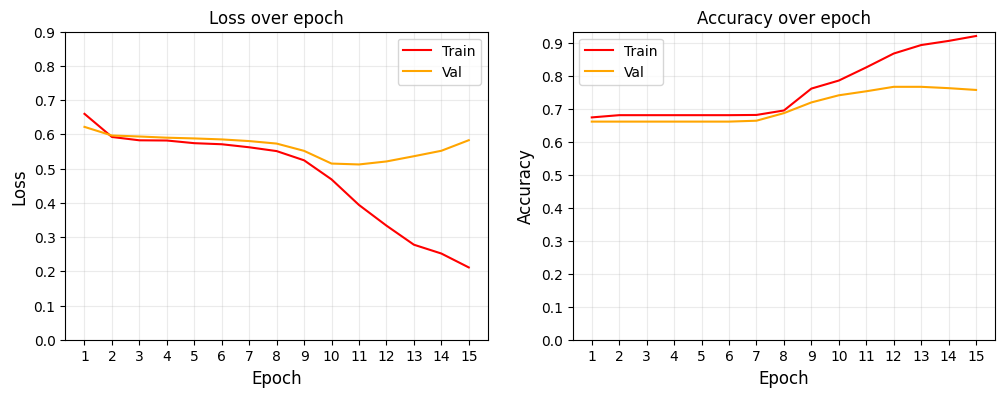

In [85]:
performance_plot(history_lstm)

In [86]:
y_pre = model_lstm.predict(test_padseq)
y_pre_label = np.round(y_pre).astype(int).reshape(-1)

incorrect_indexes=np.nonzero(y_pre_label != y_test)[0]

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


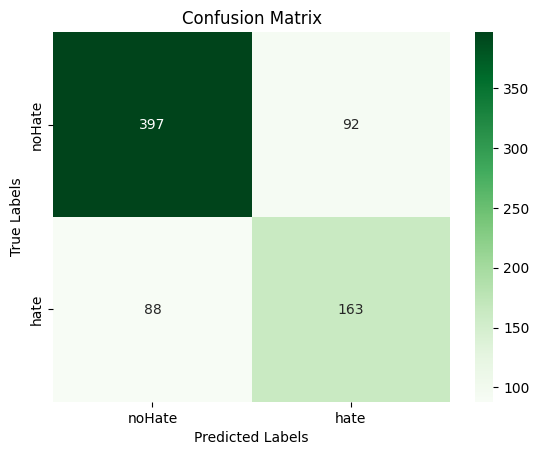

In [87]:
# Create the confusion matrix
cmf = confusion_matrix(y_test, y_pre_label)

# Display the confusion matrix as a heatmap
sns.heatmap(cmf, annot=True, fmt='d', cmap='Greens', xticklabels=['noHate', 'hate'], yticklabels=['noHate', 'hate'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [88]:
# For binary classification, use a threshold of 0.5 to classify as 0 or 1
y_pred = (y_pre > 0.5).astype("int32")

# Identify Misclassified Instances
misclassified_mask = (y_pred.flatten() != y_test)

# Filter Misclassified Texts and Their Corresponding Labels
misclassified_text = X_test[misclassified_mask]
misclassified_true_labels = y_test[misclassified_mask]
misclassified_pred_labels = y_pred.flatten()[misclassified_mask]

# Create a DataFrame to Display Misclassified Text with Labels
misclassified_df = pd.DataFrame({
    'Misclassified Text': misclassified_text,
    'True Label': misclassified_true_labels,
    'Predicted Label': misclassified_pred_labels
})

# Display Only the First 5 Misclassified Examples
misclassified_sample = misclassified_df.head(5)

# Print the examples
for _, row in misclassified_sample.iterrows():
    print(f"Misclassified Text: {row['Misclassified Text']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print("-" * 80)


Misclassified Text: i can only pray this babboon mongoloid do n't have any child so his seed will not continue on on this earth
True Label: 1
Predicted Label: 0
--------------------------------------------------------------------------------
Misclassified Text: let 's hope he 's right and that the head of the marxist elites currently rule europe start to roll
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------------------
Misclassified Text: the problem be in black ' head but hey you have already know that
True Label: 1
Predicted Label: 0
--------------------------------------------------------------------------------
Misclassified Text: i 'm with you winnipeg have become a cesspool
True Label: 1
Predicted Label: 0
--------------------------------------------------------------------------------
Misclassified Text: protest catholic guilt mongering and intellectual deprivation be a worthy of mention a the protesting of institutionalized a